# Get At-Risk Customers Using Business Metrics

In [1]:
import os
from datetime import datetime
from io import BytesIO, StringIO
from pathlib import Path

import boto3
import botocore.exceptions
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Markdown

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

In [4]:
import cc_churn.costs as costs
import cc_churn.visualization as vzu

## About

Get the at-risk customers and determine how many customers should be selected in order to maximize true ROI while minimizing error in predicted ROI.

## User Inputs

In [5]:
# R2 data bucket details
bucket_name = 'cc-churn-splits'
# # name of validation data with predictions key (file) in private R2 bucket
r2_key_val_partial = 'validation_predictions__logisticregression__'
# # name of validation data with predictions key (file) in private R2 bucket
r2_key_test_partial = 'test_predictions__logisticregression__'

# columns to load
columns = [
    'clientnum',
    'card_category',
    'total_revolv_bal',
    'total_trans_amt',
    'model_name',
    'y_pred_proba',
    'y_pred',
    'best_decision_threshold',
    'is_churned',
]

# costs
# # revenue from transactions (bank earns #% of transaction volume)
interchange_rate = 0.02
# # revenue from revolving balance (~20% interest)
apr = 0.18
# # fee revenue from credit card exposure (modeled from card type)
card_fees = {"Blue": 0, "Silver": 50, "Gold": 100, "Platinum": 200}
tenure_years = 3
discount = 0.9
# # percentage of churners who can be convinced to stay (i.e. success rate
# # of saving a churning customer)
success_rate = 0.40
# # cost of intervention to get a single customer to not churn (discounts,
# # call center time, retention offers, etc.)
intervention_cost = 50
# # maximum number of customers that can be targeted based on client's budget
num_customers_max = 100

In [6]:
account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID')
secret_access_key = os.getenv('SECRET_ACCESS_KEY')

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

# costs
multiplier = (1 - discount**tenure_years) / (1 - discount)

In [7]:
def pandas_read_parquet_r2(bucket_name, r2_key, columns):
    """Read parquet file from private R2 bucket."""
    s3_object = s3_client.get_object(Bucket=bucket_name, Key=r2_key)
    df = pd.read_parquet(
        BytesIO(s3_object['Body'].read()),
        columns=columns,
        dtype_backend='pyarrow',
    )
    return df


def pandas_read_filtered_parquets_r2(bucket_name, key_prefix, cols_to_load):
    """Read parquet files using partial filename from private R2 bucket."""
    s3_objects = s3_client.list_objects_v2(
        Bucket=bucket_name, Prefix=key_prefix, MaxKeys=1
    )
    assert s3_objects['ResponseMetadata']['HTTPStatusCode'] == 200
    df = pd.concat(
        [
            pandas_read_parquet_r2(
                bucket_name, obj['Key'], columns=cols_to_load
            )
            for obj in s3_objects['Contents']
        ],
        ignore_index=True,
    )
    return df


def export_df_to_r2(df, bucket_name, r2_key):
    """Export DataFrame to file in private R2 bucket, if not present."""
    try:
        s3_client.head_object(Bucket=bucket_name, Key=r2_key)
        print(f"Key {r2_key} already exists in bucket {bucket_name}")
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "404":
            print(f"Key {r2_key} does not exist in bucket {bucket_name}")
            buffer = BytesIO()
            df.to_parquet(
                buffer,
                index=False,
                engine='pyarrow',
                compression='gzip',
            )
            response = s3_client.put_object(
                Bucket=bucket_name, Key=r2_key, Body=buffer.getvalue()
            )
            assert response['ResponseMetadata']['HTTPStatusCode'] == 200
            print(f"Exported {len(df):,} rows to key: {r2_key}")
        elif e.response["Error"]["Code"] == "403":
            print(f"Access denied to bucket {bucket_name} or key {r2_key}")
        else:
            print(f"An unexpected error occurred: {e}")

## Load Data with Predictions

Load validation data with predictions

In [8]:
%%time
df_val_pred = pandas_read_filtered_parquets_r2(
    bucket_name, r2_key_val_partial, columns
)
print(f"Got {len(df_val_pred):,} rows of validation split predictions")
with pd.option_context('display.max_columns', None):
    display(df_val_pred)

Got 1,427 rows of validation split predictions


,clientnum,card_category,total_revolv_bal,total_trans_amt,model_name,y_pred_proba,y_pred,best_decision_threshold,is_churned
0,816086508,Blue,0.0,4624.0,LogisticRegression,0.565682,1,0.5,0
1,715749858,Blue,1380.0,1723.0,LogisticRegression,0.56938,1,0.5,0
2,795991758,Blue,660.0,4079.0,LogisticRegression,0.273788,0,0.5,0
3,771594783,Blue,0.0,2264.0,LogisticRegression,0.989876,1,0.5,1
4,771502383,Blue,1539.0,4884.0,LogisticRegression,0.311991,0,0.5,0
...,...,...,...,...,...,...,...,...,...
1422,713366583,Blue,1685.0,1405.0,LogisticRegression,0.295411,0,0.5,0
1423,789684258,Silver,1847.0,7842.0,LogisticRegression,0.795347,1,0.5,1
1424,714115533,Blue,1789.0,2591.0,LogisticRegression,0.020326,0,0.5,0
1425,767574108,Blue,786.0,4094.0,LogisticRegression,0.26742,0,0.5,0


CPU times: user 85.3 ms, sys: 8.83 ms, total: 94.1 ms
Wall time: 510 ms


Load test data with predictions

In [9]:
%%time
df_test_pred = pandas_read_filtered_parquets_r2(
    bucket_name, r2_key_test_partial, columns
)
print(f"Got {len(df_test_pred):,} rows of test split predictions")
with pd.option_context('display.max_columns', None):
    display(df_test_pred)

Got 1,718 rows of test split predictions


,clientnum,card_category,total_revolv_bal,total_trans_amt,model_name,y_pred_proba,y_pred,best_decision_threshold,is_churned
0,721418133,Blue,972.0,4535.0,LogisticRegression,0.028622,0,0.5,0
1,719513733,Blue,0.0,4276.0,LogisticRegression,0.495681,0,0.5,0
2,721043058,Blue,2149.0,1700.0,LogisticRegression,0.042856,0,0.5,0
3,718435158,Blue,0.0,1930.0,LogisticRegression,0.82207,1,0.5,0
4,711336033,Blue,1032.0,4080.0,LogisticRegression,0.151568,0,0.5,0
...,...,...,...,...,...,...,...,...,...
1713,719674533,Blue,1527.0,4040.0,LogisticRegression,0.017024,0,0.5,0
1714,757024233,Blue,2152.0,2555.0,LogisticRegression,0.093265,0,0.5,0
1715,710784333,Blue,1314.0,1644.0,LogisticRegression,0.681264,1,0.5,0
1716,795613233,Blue,1494.0,4949.0,LogisticRegression,0.008574,0,0.5,0


CPU times: user 20.6 ms, sys: 1.97 ms, total: 22.6 ms
Wall time: 173 ms


Extract best decision threshold from model predictions of the validation data

In [10]:
best_decision_threshold = df_val_pred['best_decision_threshold'].head(1).squeeze()

Extract name of best ML model from model predictions of the validation data

In [11]:
best_model_name = df_val_pred['model_name'].head(1).squeeze()

## Model Validation

### Costs

Calculate the true savings, expected (predicted) savings and error in predicted savings (cost) using the validation data

In [12]:
%%time
df_costs_val, _, _ = costs.get_cost(
    df_val_pred,
    best_decision_threshold,
    interchange_rate,
    apr,
    card_fees,
    multiplier,
    success_rate,
    intervention_cost,
)
with pd.option_context('display.max_columns', None):
    display(df_costs_val)

,clientnum,card_category,total_revolv_bal,total_trans_amt,model_name,y_pred_proba,y_pred,best_decision_threshold,is_churned,interchange_rev,interest_rev,fee_rev,annual_rev,clv,success_rate,expected_savings,true_savings,cum_pred_savings,cum_true_savings,n,random_savings,total_intervention_cost,ROI,ROI_pred,ROI_error,ROI_percent,ROI_percent_pred
0,713980383,Blue,0.0,1902.0,LogisticRegression,0.998646,1,0.5,1,38.04,0.0,0,38.04,103.0884,0.4,-8.820477,-8,-8.820477,-8,1,33.128866,50,-0.160000,-0.17641,-10.255957,-16.000000,-17.640953
1,752604633,Blue,0.0,761.0,LogisticRegression,0.997844,1,0.5,1,15.22,0.0,0,15.22,41.2462,0.4,-33.537085,-33,-42.357561,-41,2,66.257732,100,-0.410000,-0.423576,-3.311126,-41.000000,-42.357561
2,710586483,Blue,0.0,968.0,LogisticRegression,0.997642,1,0.5,1,19.36,0.0,0,19.36,52.4656,0.4,-29.063245,-29,-71.420807,-70,3,99.386598,150,-0.466667,-0.476139,-2.029724,-46.666667,-47.613871
3,711357858,Blue,0.0,777.0,LogisticRegression,0.997512,1,0.5,1,15.54,0.0,0,15.54,42.1134,0.4,-33.196543,-33,-104.61735,-103,4,132.515464,200,-0.515000,-0.523087,-1.570243,-51.500000,-52.308675
4,712551258,Blue,0.0,847.0,LogisticRegression,0.997101,1,0.5,1,16.94,0.0,0,16.94,45.9074,0.4,-31.690266,-31,-136.307616,-134,5,165.644330,250,-0.536000,-0.54523,-1.722101,-53.600000,-54.523046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,715530258,Blue,2517.0,2353.0,LogisticRegression,0.510098,1,0.5,1,47.06,453.06,0,500.12,1355.3252,0.4,226.539718,492,44004.70881,13054,384,12721.484536,19200,0.679896,2.291912,-237.097509,67.989583,229.191192
384,709385133,Blue,1513.0,15572.0,LogisticRegression,0.507603,1,0.5,0,311.44,272.34,0,583.78,1582.0438,0.4,271.219943,-50,44275.928753,13004,385,12754.613402,19250,0.675532,2.300048,-240.479304,67.553247,230.004825
385,717998058,Blue,2019.0,2644.0,LogisticRegression,0.505672,1,0.5,0,52.88,363.42,0,416.3,1128.173,0.4,178.194407,-50,44454.12316,12954,386,12787.742268,19300,0.671192,2.303322,-243.169084,67.119171,230.332244
386,709779258,Blue,0.0,4075.0,LogisticRegression,0.503756,1,0.5,0,81.5,0.0,0,81.5,220.865,0.4,-5.495135,-50,44448.628025,12904,387,12820.871134,19350,0.666873,2.297087,-244.4562,66.687339,229.708672


CPU times: user 28.4 ms, sys: 1.96 ms, total: 30.3 ms
Wall time: 29.8 ms


**Notes**

1. The following columns are related to the business costs and are discussed in the [project scoping document](https://github.com/edesz/credit-card-churn/blob/main/references/01_proposal.md)
   - `interchange_rev`
   - `interest_rev`
   - `fee_rev`
   - `annual_rev`
   - `clv`
   - `success_rate`
   - `expected_savings`
   - `true_savings`
   - `cum_pred_savings`
   - `cum_true_savings`
   - `n`
   - `total_intervention_cost`
   - `ROI`
   - `ROI_pred`
   - `ROI_error`
   - `ROI_percent`
   - `ROI_percent_pred`
2. The costs are only calculated for customers that are predicted to churn since these are the customers that will be targeted. For this reason, there are fewer rows in the costs `DataFrame` (`df_costs_val`) than in the `DataFrame` with the ML model predictions for the validation data (`df_val_pred`).
3. ROI is a business-focused Key Performance Indicator (KPI). It provides a broader view of the financial efficiency of an entire investment, considering both costs and gains. So, the KPI that should be reported to the client is the expected (predicted) ROI.

### Use True ROI and Error in Predicted ROI to Optimize Number of Targeted Customers (`N`)

Plot true and predicted expected savings and ROI curves to visualize the following

1. true ROI
2. predicted ROI

using the validation data

CPU times: user 32.4 ms, sys: 1.03 ms, total: 33.5 ms
Wall time: 32.8 ms


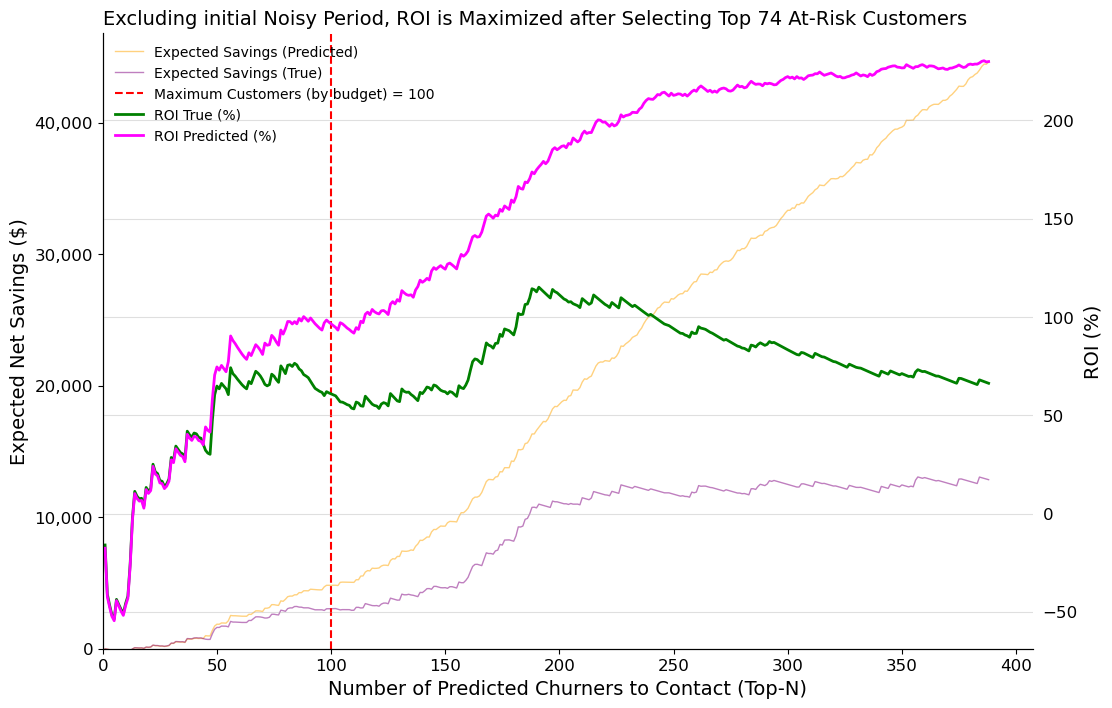

In [13]:
%%time
vzu.plot_roi_curves(
    df_costs_val['n'],
    df_costs_val['cum_true_savings'],
    df_costs_val['cum_pred_savings'],
    df_costs_val['ROI_percent'],
    df_costs_val['ROI_percent_pred'],
    {
        f'Maximum Customers (by budget) = {num_customers_max}': {
            'x': num_customers_max, 'colour': 'red'
        },
    },
    ptitle=(
        'Excluding initial Noisy Period, ROI is Maximized after Selecting Top '
        '74 At-Risk Customers'
    ),
    legend_loc='upper left',
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    ylabel="Expected Net Savings ($)",
    fig_size=(12, 8),
)

**Notes**

1. The model cost is the error in predicted ROI.

**Observations**

1. The true and predicted ROI is noisy when selecting a small number of churners (less than approximately 50 churners). As explained below, individual customers are make an outsized contribution to the overall ROI for `N` < ~50.
2. Excluding the initial ROI increases, the peak in optimal `N` is at ~75 customers (churners), the true ROI value reaches a maximum of ~150% at ~75, then drops to ~105% at ~180 and then increases to ~140% at ~210.
3. Based on the observations in this chart, if the value of `N` is selected to be ~75, the ROI is maximized and the error in predicted ROI from the best ML model is minimal. This choice of `N` is an optimal balance between true ROI and error in ROI predicted by the best ML model.

Below are selected components involved in the calculation of ROI to explore the source of the initial noisy period in the ROI from the above chart

In [14]:
cols_table = [
    'n',
    'y_pred_proba',
    'total_revolv_bal',
    'interchange_rev',
    'interest_rev',
    'fee_rev',
    'annual_rev',
    'expected_savings',
    'ROI_percent',
]
with pd.option_context('display.max_rows', None):
    display(
        df_costs_val[cols_table]
        .head(15)
        .style
        .set_properties(
            subset=['interest_rev', 'fee_rev', 'expected_savings', 'ROI_percent'],
            **{'background-color': 'yellow', 'color': 'black'}
        )
    )

,n,y_pred_proba,total_revolv_bal,interchange_rev,interest_rev,fee_rev,annual_rev,expected_savings,ROI_percent
0,1,0.998646,0.000000,38.040000,0.000000,0,38.040000,-8.820477,-16.000000
1,2,0.997844,0.000000,15.220000,0.000000,0,15.220000,-33.537085,-41.000000
2,3,0.997642,0.000000,19.360000,0.000000,0,19.360000,-29.063245,-46.666667
3,4,0.997512,0.000000,15.540000,0.000000,0,15.540000,-33.196543,-51.500000
4,5,0.997101,0.000000,16.940000,0.000000,0,16.940000,-31.690266,-53.600000
5,6,0.996938,0.000000,49.380000,0.000000,0,49.380000,3.364035,-43.666667
6,7,0.995673,0.000000,17.000000,0.000000,0,17.000000,-31.651737,-46.285714
7,8,0.995225,0.000000,14.780000,0.000000,0,14.780000,-34.054987,-48.750000
8,9,0.994965,0.000000,14.340000,0.000000,0,14.340000,-34.533700,-50.888889
9,10,0.994806,0.000000,45.380000,0.000000,0,45.380000,-1.063564,-45.800000


**Observations**

1. There are three terms that cause fluctuations in the calculation of annual revenue (and consequently in the calculation of expected savings and ROI) when a small number of customers are selected
   - `interest_rev` (depending on `total_revolv_bal`)
   - `fee_rev` (depending on `card_category`)

   This results in strong fluctuations in ROI if selecting a small number of customers. The overall ROI is highly sensitive to contributions from a small number of customers here. This causes the noisy patterns in both true and predicted ROI in the above chart when targeting less than approximately 55 customers.

Find the optimal number of customers to target in order to maximize predicted ROI, using the costs on the validation data

In [15]:
%%time
df_costs_optimal = (
    df_costs_val
    .query(
        "(total_intervention_cost > 0) & "
        # avoid initial noisy period where few customers have dominant
        # impact on cumulative ROI
        "(n >= 50) & "
        # enforce limit based on client's budget
        f"(n <= {num_customers_max})"
    )
    .sort_values(
        by=['ROI', 'ROI_error', 'n'], ascending=[False, True, True],
        ignore_index=True,
    )
    .head(1)
)
optimal_N_roi = df_costs_optimal['n'].squeeze()
cols_costs = [
    'n',
    'cum_true_savings',
    'cum_pred_savings',
    'ROI_error',
    'ROI_percent',
    'ROI_percent_pred',
]
(
    df_costs_optimal[cols_costs]
    .style
    .set_properties(
        subset=['ROI_error', 'ROI_percent_pred'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

CPU times: user 8.47 ms, sys: 969 μs, total: 9.44 ms
Wall time: 8.98 ms


,n,cum_true_savings,cum_pred_savings,ROI_error,ROI_percent,ROI_percent_pred
0,84,3210,4100.182983,-27.731557,76.428571,97.623404


In [16]:
roi_error_optimal_val = df_costs_optimal['ROI_error'].squeeze()
predicted_roi_optimal_val = df_costs_optimal['ROI_percent_pred'].squeeze()
Markdown(
    "**Observations**\n"
    "1. In order to maximize true ROI and minimize the error in predicted "
    f"ROI, the optimal number of customers to target is {optimal_N_roi}. "
    "This is consistent with observations from the chart above.\n"
    f"2. If the top {optimal_N_roi} customers from the test data are "
    "targeted, then the\n"
    "   - error in the predicted ROI is approximately "
    f"{roi_error_optimal_val:.1f}%\n"
    f"   - predicted ROI is approximately {predicted_roi_optimal_val:.1f}%"
)

**Observations**
1. In order to maximize true ROI and minimize the error in predicted ROI, the optimal number of customers to target is 84. This is consistent with observations from the chart above.
2. If the top 84 customers from the test data are targeted, then the
   - error in the predicted ROI is approximately -27.7%
   - predicted ROI is approximately 97.6%

## Model Evaluation

### Class Imbalance

Get the true and predicted class imbalance for the test data

In [17]:
%%time
df_true_pred_class_imbalance = (
    (
        df_test_pred['y_pred']
        .value_counts(normalize=True)
        .rename('predicted')
        .to_frame()
    )
    .merge(
        (
            df_test_pred['is_churned']
            .value_counts(normalize=True)
            .rename('true')
            .to_frame()
        ),
        left_index=True,
        right_index=True,
    )
)
df_true_pred_class_imbalance.index = df_true_pred_class_imbalance.index.map(
    {0: 'No Churn', 1: 'Churn'}
)
df_true_pred_class_imbalance

CPU times: user 2.98 ms, sys: 6 μs, total: 2.98 ms
Wall time: 2.85 ms


,predicted,true
y_pred,,
No Churn,0.747381,0.839348
Churn,0.252619,0.160652


**Observations**

1. The class imbalance in the test split is approximately the same as that in the training split (~84%:16%).
2. Due to the inaccuracy of the model, the class imbalance of the predictions is ~75%:25% which means ~25% instead of ~16% of customers are predicted to churn (i.e. ~25% of customers are predicted to cancel their credit card).

The class imbalance in the validation and test data is shown below

In [18]:
%%time
df_val_test_true_class_imbalance = (
    df_val_pred['is_churned']
    .value_counts(normalize=True)
    .rename('validation')
    .to_frame()
    .merge(
        df_test_pred['is_churned'].value_counts(normalize=True).rename('test').to_frame(),
        left_index=True,
        right_index=True,
        how='left',
    )
)
df_val_test_true_class_imbalance.index = df_val_test_true_class_imbalance.index.map(
    {0: 'No Churn', 1: 'Churn'}
)
df_val_test_true_class_imbalance

CPU times: user 2.91 ms, sys: 0 ns, total: 2.91 ms
Wall time: 2.69 ms


,validation,test
is_churned,,
No Churn,0.839523,0.839348
Churn,0.160477,0.160652


**Notes**

1. It is reassuring that the class imbalances are nearly equivalent between the validation and test splits. Patterns seen in during model validation should not be impacted by changes of the class imbalance during model evaluation.

Show the class imbalance and distribution of prediction probabilities for the test data

CPU times: user 62.8 ms, sys: 1.94 ms, total: 64.8 ms
Wall time: 64.4 ms


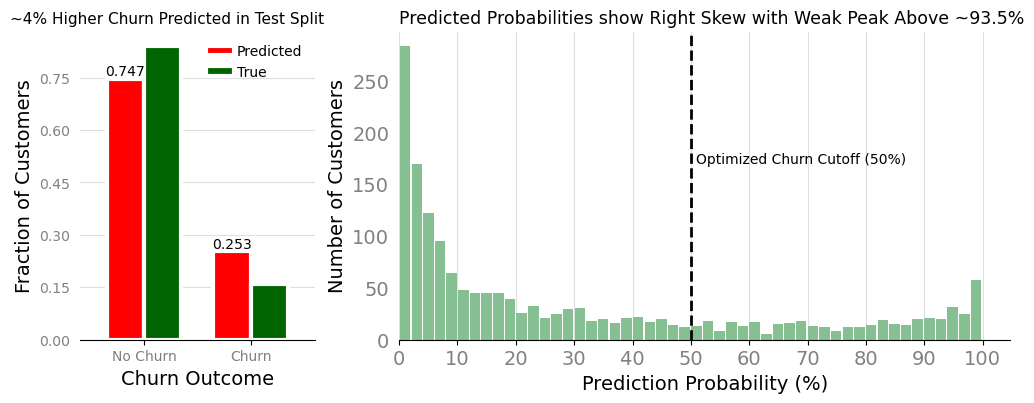

In [19]:
%%time
vzu.plot_class_imbalance_proba_distribution(
    df_clasS_imbalance=df_true_pred_class_imbalance.rename(columns=str.title),
    df_probabilities=(df_test_pred['y_pred_proba']*100),
    ptitle1='~4% Higher Churn Predicted in Test Split',
    title1_xloc=-0.3,
    ptitle2=(
        'Predicted Probabilities show Right Skew with Weak Peak Above ~93.5%'
    ),
    vline_label=f'Optimized Churn Cutoff ({best_decision_threshold*100:.0f}%)',
    decision_threshold=best_decision_threshold,
    subfigure_width_ratios=[1.15, 3],
    fig_size=(12, 4)
)

**Observations**

1. As expected from the predicted class imbalance, the distribution of predicted probabilities is right-skewed and a small fraction of customers have a predicted probability above 50% (the tuned classification decision threshold).

### Costs

Calculate the true savings, expected (predicted) savings and error in predicted savings (cost) using the test data

In [20]:
%%time
df_costs_test, _, _ = costs.get_cost(
    df_test_pred,
    best_decision_threshold,
    interchange_rate,
    apr,
    card_fees,
    multiplier,
    success_rate,
    intervention_cost,
)
with pd.option_context('display.max_columns', None):
    display(df_costs_test)

,clientnum,card_category,total_revolv_bal,total_trans_amt,model_name,y_pred_proba,y_pred,best_decision_threshold,is_churned,interchange_rev,interest_rev,fee_rev,annual_rev,clv,success_rate,expected_savings,true_savings,cum_pred_savings,cum_true_savings,n,random_savings,total_intervention_cost,ROI,ROI_pred,ROI_error,ROI_percent,ROI_percent_pred
0,720610008,Blue,812.0,1339.0,LogisticRegression,0.998598,1,0.5,1,26.78,146.16,0,172.94,468.6674,0.4,137.204106,137,137.204106,137,1,46.624424,50,2.740000,2.744082,-0.148983,274.000000,274.408213
1,711013983,Blue,0.0,615.0,LogisticRegression,0.998323,1,0.5,1,12.3,0.0,0,12.3,33.333,0.4,-36.689158,-36,100.514948,101,2,93.248848,100,1.010000,1.005149,0.480249,101.000000,100.514948
2,789270033,Silver,0.0,1122.0,LogisticRegression,0.998058,1,0.5,0,22.44,0.0,50,72.44,196.3124,0.4,28.372433,-50,128.887381,51,3,139.873272,150,0.340000,0.859249,-152.720355,34.000000,85.924921
3,714871683,Blue,537.0,715.0,LogisticRegression,0.997253,1,0.5,1,14.3,96.66,0,110.96,300.7016,0.4,69.950257,70,198.837638,121,4,186.497696,200,0.605000,0.994188,-64.328626,60.500000,99.418819
4,708655983,Blue,0.0,1353.0,LogisticRegression,0.996726,1,0.5,0,27.06,0.0,0,27.06,73.3326,0.4,-20.763006,-50,178.074632,71,5,233.122120,250,0.284000,0.712299,-150.80934,28.400000,71.229853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,711957708,Blue,1591.0,2064.0,LogisticRegression,0.509763,1,0.5,0,41.28,286.38,0,327.66,887.9586,0.4,131.059297,-50,50985.466646,20435,430,20048.502304,21500,0.950465,2.371417,-149.500693,95.046512,237.141705
430,713889933,Blue,0.0,1536.0,LogisticRegression,0.50894,1,0.5,0,30.72,0.0,0,30.72,83.2512,0.4,-33.052067,-50,50952.414579,20385,431,20095.126728,21550,0.945940,2.364381,-149.950525,94.593968,236.438119
431,715859058,Blue,2165.0,1369.0,LogisticRegression,0.506511,1,0.5,0,27.38,389.7,0,417.08,1130.2868,0.4,179.001074,-50,51131.415654,20335,432,20141.751152,21600,0.941435,2.367195,-151.445368,94.143519,236.719517
432,721022433,Blue,2480.0,1409.0,LogisticRegression,0.504637,1,0.5,0,28.18,446.4,0,474.58,1286.1118,0.4,209.607792,-50,51341.023446,20285,433,20188.375576,21650,0.936952,2.37141,-153.098464,93.695150,237.140986


CPU times: user 31.9 ms, sys: 54 μs, total: 32 ms
Wall time: 31.2 ms


**Notes**

1. The column names are identical to those in the costs calculated using the validation data (`df_costs_val`).

### Use True ROI and Error in Predicted ROI to Optimize Number of Targeted Customers (`N`)

Find the optimal number of customers to target in order to maximize true predicted ROI, using the costs from the test data

In [21]:
%%time
df_costs_optimal_test = (
    df_costs_test
    .query(
        "(total_intervention_cost > 0) & "
        # avoid initial noisy period where few customers have dominant
        # impact on cumulative ROI
        "(n > 30) & "
        # enforce limit based on client's budget
        f"(n <= {num_customers_max})"
    )
    .sort_values(
        by=['ROI', 'ROI_error', 'n'], ascending=[False, True, True],
        ignore_index=True,
    )
    .head(1)
)
cols_costs = [
    'n',
    'cum_true_savings',
    'cum_pred_savings',
    'ROI_error',
    'ROI_percent',
    'ROI_percent_pred',
]
optimal_N_roi_test = df_costs_optimal_test['n'].squeeze()
(
    df_costs_optimal_test[cols_costs].assign(split='test')
    .style
    .set_properties(
        subset=['ROI_percent_pred'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

CPU times: user 7.47 ms, sys: 970 μs, total: 8.44 ms
Wall time: 8.05 ms


,n,cum_true_savings,cum_pred_savings,ROI_error,ROI_percent,ROI_percent_pred,split
0,41,2478,2543.744104,-2.653112,120.878049,124.085078,test


In [22]:
roi_error_optimal = df_costs_optimal_test['ROI_error'].squeeze()
predicted_roi_optimal = df_costs_optimal_test['ROI_percent_pred'].squeeze()
Markdown(
    "**Observations**\n"
    "1. In order to maximize true ROI and minimize the error in predicted "
    f"ROI, the optimal number of customers to target is {optimal_N_roi_test}.\n"
    f"2. If the top {optimal_N_roi_test} customers from the test data are "
    "targeted, then the\n"
    f"   - error in the predicted ROI is approximately {roi_error_optimal:.1f}%\n"
    f"   - predicted ROI is approximately {predicted_roi_optimal:.1f}%"
)

**Observations**
1. In order to maximize true ROI and minimize the error in predicted ROI, the optimal number of customers to target is 41.
2. If the top 41 customers from the test data are targeted, then the
   - error in the predicted ROI is approximately -2.7%
   - predicted ROI is approximately 124.1%

Plot true and predicted expected savings and ROI curves to visualize the following

1. true ROI
2. predicted ROI
3. optimal number of customers based on error in predicted ROI

using the test data, and compare to the optimal number of customers based on error in predicted ROI using the test data

CPU times: user 19.8 ms, sys: 997 μs, total: 20.8 ms
Wall time: 20.4 ms


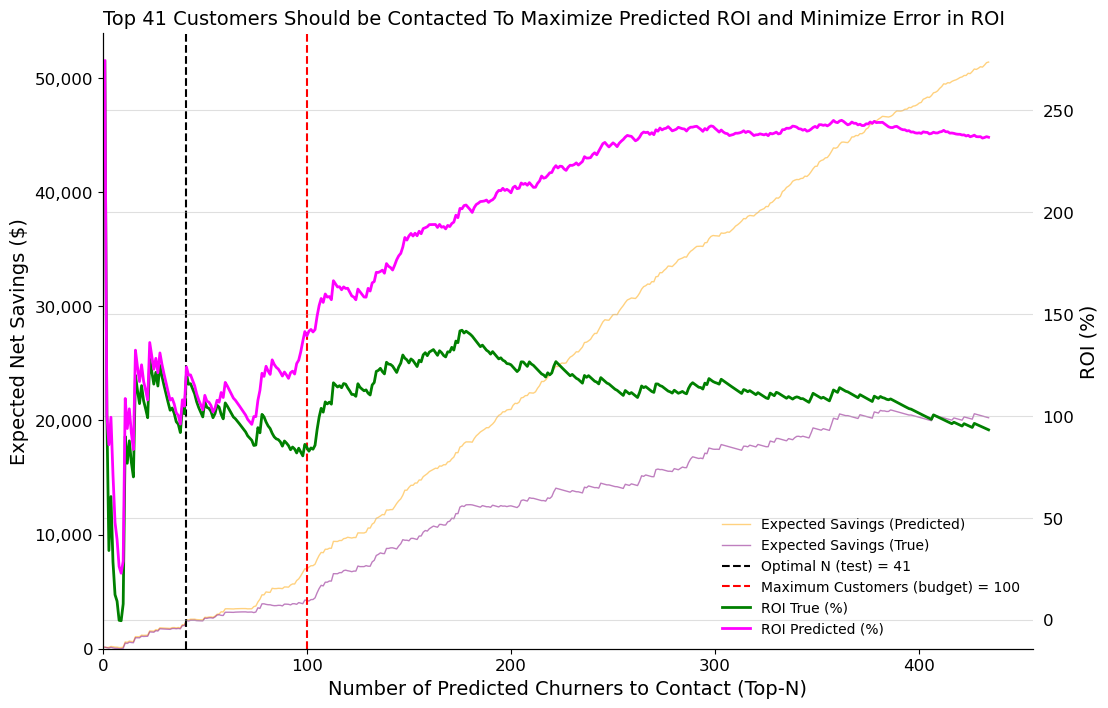

In [23]:
%%time
vzu.plot_roi_curves(
    df_costs_test['n'],
    df_costs_test['cum_true_savings'],
    df_costs_test['cum_pred_savings'],
    df_costs_test['ROI_percent'],
    df_costs_test['ROI_percent_pred'],
    {
        f'Optimal N (test) = {optimal_N_roi_test}': {
            'x': optimal_N_roi_test, 'colour': 'black',
        },
        f'Maximum Customers (budget) = {num_customers_max}': {
            'x': num_customers_max, 'colour': 'red'
        },
    },
    ptitle=(
        f'Top {optimal_N_roi_test:,} Customers Should be Contacted To Maximize '
        'Predicted ROI and Minimize Error in ROI'
    ),
    legend_loc='lower right',
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    ylabel="Expected Net Savings ($)",
    fig_size=(12, 8),
)

**Observations**

1. This chart confirms that 201 is indeed the optimal number of customers in order to maximize true ROI (green curve). After contacting ~125 customers, the true ROI decreases up to ~160 customers and then increases to a maximum (after 201 customers).
2. The predicted ROI (thick magenta line) is close to the true ROI up to approximately the optimal number of customers (201). After this, the true and predicted ROI curves diverge strongly.

### Get Loss in Predicted ROI Using Optimized Number of Targeted Customers (`N`)

We must follow the recommendations from model validation that the top 74 predicted churners should be contacted. If we do this, then we can calculate the percent change in the KPI (predicted ROI) compared to this optimal value (74). This percent change is the predicted loss in ROI that will be incurred by the client by following the recommendations from the validation data

In [24]:
%%time
df_costs_test_best = (
    df_costs_test[['n', 'y_pred_proba', 'cum_pred_savings', 'ROI_percent_pred']]
    .query(f"(n == {optimal_N_roi}) | (n == {optimal_N_roi_test})")
    .sort_values(by=['n'], ascending=True, ignore_index=True)
    .assign(
        pct_pred_ROI_lost=lambda df: (
            100*df['ROI_percent_pred'].pct_change()
        ),
        source_for_n=lambda df: pd.Series(
            ['validation data', 'test data'], index=df.index
        )
    )
)
display(
    df_costs_test_best
    .style
    .set_properties(
        subset=['cum_pred_savings', 'ROI_percent_pred', 'pct_pred_ROI_lost'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

,n,y_pred_proba,cum_pred_savings,ROI_percent_pred,pct_pred_ROI_lost,source_for_n
0,41,0.984068,2543.744104,124.085078,,validation data
1,84,0.958150,5265.248903,125.363069,1.029931,test data


CPU times: user 9.91 ms, sys: 12 μs, total: 9.92 ms
Wall time: 9.07 ms


**Notes**

1. Calculations are performed using customers in the unseen (test) data split.

**Observations**

1. If we apply the recommendations from model validation and contact (target) the top 74 customers in unseen data (test split), then the client is incorrectly reported a gain of approximately 9.91% of the maximum possible predicted ROI (which occurs for 201 customers instead of 74).

Append column to costs indicating if targeting customer maximizes ROI

In [25]:
df_costs_test = (
    df_costs_test
    .assign(maximizes_roi=lambda df: df['n'] <= optimal_N_roi)
)
(
    df_costs_test
    [
        [
            'clientnum',
            'n',
            'y_pred_proba',
            'y_pred',
            'clv',
            'ROI_percent_pred',
            'maximizes_roi',
        ]
    ]
)

,clientnum,n,y_pred_proba,y_pred,clv,ROI_percent_pred,maximizes_roi
0,720610008,1,0.998598,1,468.6674,274.408213,True
1,711013983,2,0.998323,1,33.333,100.514948,True
2,789270033,3,0.998058,1,196.3124,85.924921,True
3,714871683,4,0.997253,1,300.7016,99.418819,True
4,708655983,5,0.996726,1,73.3326,71.229853,True
...,...,...,...,...,...,...,...
429,711957708,430,0.509763,1,887.9586,237.141705,False
430,713889933,431,0.50894,1,83.2512,236.438119,False
431,715859058,432,0.506511,1,1130.2868,236.719517,False
432,721022433,433,0.504637,1,1286.1118,237.140986,False


### At-Risk Customers

In order to identify at-risk customers from the `y_pred_proba` (predicted probability) column, we must pick an optimal decision threshold based on the business goal (catching true churners). For the current business use-case, we need to prioritize recall. The optimal decision threshold was determined during ML development.

This decision threshold was optimized to maximize F2 Score, since it prioritizes recall over precision, which is in line with the business goal. The tuned threshold is stored in the `best_decision_threshold` column of `df_val_pred` and `df_test_pred`. The `y_pred` column was created by comparing `y_pred_proba` to the best decision threshold. With this in mind, the `y_pred` column already indicates if a customer is at-risk (1) or not (0).

So, the `y_pred` column will now be renamed to `is_at_risk`

In [26]:
%%time
df_costs_test = df_costs_test.rename(columns={'y_pred': 'is_at_risk'})
with pd.option_context('display.max_columns', None):
    display(df_costs_test)

,clientnum,card_category,total_revolv_bal,total_trans_amt,model_name,y_pred_proba,is_at_risk,best_decision_threshold,is_churned,interchange_rev,interest_rev,fee_rev,annual_rev,clv,success_rate,expected_savings,true_savings,cum_pred_savings,cum_true_savings,n,random_savings,total_intervention_cost,ROI,ROI_pred,ROI_error,ROI_percent,ROI_percent_pred,maximizes_roi
0,720610008,Blue,812.0,1339.0,LogisticRegression,0.998598,1,0.5,1,26.78,146.16,0,172.94,468.6674,0.4,137.204106,137,137.204106,137,1,46.624424,50,2.740000,2.744082,-0.148983,274.000000,274.408213,True
1,711013983,Blue,0.0,615.0,LogisticRegression,0.998323,1,0.5,1,12.3,0.0,0,12.3,33.333,0.4,-36.689158,-36,100.514948,101,2,93.248848,100,1.010000,1.005149,0.480249,101.000000,100.514948,True
2,789270033,Silver,0.0,1122.0,LogisticRegression,0.998058,1,0.5,0,22.44,0.0,50,72.44,196.3124,0.4,28.372433,-50,128.887381,51,3,139.873272,150,0.340000,0.859249,-152.720355,34.000000,85.924921,True
3,714871683,Blue,537.0,715.0,LogisticRegression,0.997253,1,0.5,1,14.3,96.66,0,110.96,300.7016,0.4,69.950257,70,198.837638,121,4,186.497696,200,0.605000,0.994188,-64.328626,60.500000,99.418819,True
4,708655983,Blue,0.0,1353.0,LogisticRegression,0.996726,1,0.5,0,27.06,0.0,0,27.06,73.3326,0.4,-20.763006,-50,178.074632,71,5,233.122120,250,0.284000,0.712299,-150.80934,28.400000,71.229853,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,711957708,Blue,1591.0,2064.0,LogisticRegression,0.509763,1,0.5,0,41.28,286.38,0,327.66,887.9586,0.4,131.059297,-50,50985.466646,20435,430,20048.502304,21500,0.950465,2.371417,-149.500693,95.046512,237.141705,False
430,713889933,Blue,0.0,1536.0,LogisticRegression,0.50894,1,0.5,0,30.72,0.0,0,30.72,83.2512,0.4,-33.052067,-50,50952.414579,20385,431,20095.126728,21550,0.945940,2.364381,-149.950525,94.593968,236.438119,False
431,715859058,Blue,2165.0,1369.0,LogisticRegression,0.506511,1,0.5,0,27.38,389.7,0,417.08,1130.2868,0.4,179.001074,-50,51131.415654,20335,432,20141.751152,21600,0.941435,2.367195,-151.445368,94.143519,236.719517,False
432,721022433,Blue,2480.0,1409.0,LogisticRegression,0.504637,1,0.5,0,28.18,446.4,0,474.58,1286.1118,0.4,209.607792,-50,51341.023446,20285,433,20188.375576,21650,0.936952,2.37141,-153.098464,93.695150,237.140986,False


CPU times: user 15.5 ms, sys: 976 μs, total: 16.5 ms
Wall time: 15.9 ms


## Export Project Deliverables to Private R2 Bucket

Get the current timestamp in the format `YYmmdd_HHMMSS`

In [27]:
curr_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

### Unseen Data (Test Split) Customers with Indicator of At-Risk and Maximizing ROI

Combine costs (predicted churners) with predicted non-churners

In [28]:
%%time
df_test_pred_with_costs = (
    pd.concat(
        [
            df_costs_test.assign(y_pred=1),
            df_test_pred.query("y_pred != 1"),
        ],
        ignore_index=True
    )
    .fillna(
        {
            'interchange_rev': np.nan,
            'interest_rev': np.nan,
            'fee_rev': np.nan,
            'annual_rev': np.nan,
            'clv': np.nan,
            'success_rate': np.nan,
            'expected_savings': np.nan,
            'true_savings': np.nan,
            'cum_pred_savings': np.nan,
            'cum_true_savings': np.nan,
            'n': np.nan,
            'random_savings': np.nan,
            'total_intervention_cost': np.nan,
            'ROI': np.nan,
            'ROI_pred': np.nan,
            'ROI_error': np.nan,
            'ROI_percent': np.nan,
            'ROI_percent_pred': np.nan,
            'maximizes_roi': np.nan,
            'is_at_risk': 0,
        }
    )
    .convert_dtypes(dtype_backend='pyarrow')
)
with pd.option_context('display.max_columns', None):
    display(df_test_pred_with_costs)

,clientnum,card_category,total_revolv_bal,total_trans_amt,model_name,y_pred_proba,is_at_risk,best_decision_threshold,is_churned,interchange_rev,interest_rev,fee_rev,annual_rev,clv,success_rate,expected_savings,true_savings,cum_pred_savings,cum_true_savings,n,random_savings,total_intervention_cost,ROI,ROI_pred,ROI_error,ROI_percent,ROI_percent_pred,maximizes_roi,y_pred
0,720610008,Blue,812.0,1339.0,LogisticRegression,0.998598,1,0.5,1,26.78,146.16,0,172.94,468.6674,0.4,137.204106,137,137.204106,137,1,46.624424,50,2.74,2.744082,-0.148983,274.0,274.408213,True,1
1,711013983,Blue,0.0,615.0,LogisticRegression,0.998323,1,0.5,1,12.3,0.0,0,12.3,33.333,0.4,-36.689158,-36,100.514948,101,2,93.248848,100,1.01,1.005149,0.480249,101.0,100.514948,True,1
2,789270033,Silver,0.0,1122.0,LogisticRegression,0.998058,1,0.5,0,22.44,0.0,50,72.44,196.3124,0.4,28.372433,-50,128.887381,51,3,139.873272,150,0.34,0.859249,-152.720355,34.0,85.924921,True,1
3,714871683,Blue,537.0,715.0,LogisticRegression,0.997253,1,0.5,1,14.3,96.66,0,110.96,300.7016,0.4,69.950257,70,198.837638,121,4,186.497696,200,0.605,0.994188,-64.328626,60.5,99.418819,True,1
4,708655983,Blue,0.0,1353.0,LogisticRegression,0.996726,1,0.5,0,27.06,0.0,0,27.06,73.3326,0.4,-20.763006,-50,178.074632,71,5,233.12212,250,0.284,0.712299,-150.80934,28.4,71.229853,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,807722658,Blue,1250.0,4761.0,LogisticRegression,0.00762,0,0.5,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
1714,719674533,Blue,1527.0,4040.0,LogisticRegression,0.017024,0,0.5,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
1715,757024233,Blue,2152.0,2555.0,LogisticRegression,0.093265,0,0.5,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
1716,795613233,Blue,1494.0,4949.0,LogisticRegression,0.008574,0,0.5,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0


CPU times: user 35.3 ms, sys: 1.96 ms, total: 37.2 ms
Wall time: 36.7 ms


Next, export to a file in the R2 bucket with the following file name format `test_predictions_with_business_metrics__logisticregression__<current-timestamp-YYmmdd_HHMMSS>.parquet.gzip`

In [29]:
%%time
export_df_to_r2(
    df_test_pred_with_costs,
    bucket_name,
    (
        f"test_predictions_with_business_metrics__{best_model_name.lower()}__"
        f"{curr_timestamp}.parquet.gzip"
    ),
)

Key test_predictions_with_business_metrics__logisticregression__20251009_133224.parquet.gzip does not exist in bucket cc-churn-splits
Exported 1,718 rows to key: test_predictions_with_business_metrics__logisticregression__20251009_133224.parquet.gzip
CPU times: user 17.8 ms, sys: 988 μs, total: 18.8 ms
Wall time: 304 ms
